<div>
<img img class="logo" src="https://medialib.cmcdn.dk/medialibrary/51432DDB-BBE3-4327-85F4-BE3493077470/1D874B35-F493-EC11-84B2-00155D0B0901.png" style="width: 100px;" align="right">
</div>

# <center> Assignment 2 - BuyWise Analytics

### <center> KAN-CDSCV1008U  Applied Machine Learning and Data Engineering in Business Context

## Data Preprocessing

`Initial Inspection`

In [3]:
# Importing modules 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score

In [4]:
# Importing datasets 
path_frederik = "C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/"
path_mathijs = "C:/Users/blk/OneDrive/Documenten/GitHub/ML-Final/AppliedML_Assign.01/Assignment2/Data"

os.chdir(path_mathijs)
print(os.getcwd())

features = pd.read_csv("Features data set.csv")
sales = pd.read_csv("sales data-set.csv")
stores = pd.read_csv("stores data-set.csv")

C:\Users\blk\OneDrive\Documenten\GitHub\ML-Final\AppliedML_Assign.01\Assignment2\Data


In [5]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

`Data Cleaning`

In [6]:
# Forwoard fill impution for 'CPI' and 'Unemployment'
features['CPI'].fillna(method='ffill', inplace=True)
features['Unemployment'].fillna(method='ffill', inplace=True)

In [8]:
features['Week'] = features.Date.dt.isocalendar().week

In [9]:
# Imputing Markdown columns
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = features.groupby('Week')[col].transform('mean')
    features[col].fillna(weekly_avg, inplace=True)

# can't impute all values for MarkDown2 , dropping Markdown2.

features.drop('MarkDown2', axis = 1, inplace=True)
features.drop('Week', axis=1, inplace=True)
features.head()


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106,False


In [10]:
# Encoding 'IsHoliday' & 'Type'
label_encoder = LabelEncoder()
features['IsHoliday'] = label_encoder.fit_transform(features['IsHoliday'])
sales['IsHoliday'] = label_encoder.fit_transform(sales['IsHoliday'])
sales['Dept'] = label_encoder.fit_transform(sales['Dept'])
stores['Type'] = label_encoder.fit_transform(stores['Type'])

In [11]:
# Merging the data
tmp_df = pd.merge(sales, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(stores, tmp_df, on=['Store'], how='left')
df.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,0,151315,0,2010-02-05,24924.50,0,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106
1,1,0,151315,0,2010-02-12,46039.49,1,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106
2,1,0,151315,0,2010-02-19,41595.55,0,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106
3,1,0,151315,0,2010-02-26,19403.54,0,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106
4,1,0,151315,0,2010-03-05,21827.90,0,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106


In [12]:
# Scaling the data 
def normalize_col(data):
    scaler = StandardScaler()
    for col in data.columns.values.tolist():
        if col != 'Date':
            data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

df_scaled = normalize_col(df)
df_scaled.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,-1.658199,-0.885307,0.239209,-1.560345,2010-02-05,0.393782,-0.275106,-0.963798,-1.720834,2.510646,-0.110208,4.135339,-0.003344,1.018774,0.078201
1,-1.658199,-0.885307,0.239209,-1.560345,2010-02-12,1.323501,3.634961,-1.169783,-1.773177,3.380049,-0.110327,3.256627,0.230207,1.022498,0.078201
2,-1.658199,-0.885307,0.239209,-1.560345,2010-02-19,1.127829,-0.275106,-1.092810,-1.847330,0.776302,-0.127816,0.700341,0.374179,1.023697,0.078201
3,-1.658199,-0.885307,0.239209,-1.560345,2010-02-26,0.150687,-0.275106,-0.729625,-1.744825,0.170943,-0.132057,-0.100926,0.067283,1.024476,0.078201
4,-1.658199,-0.885307,0.239209,-1.560345,2010-03-05,0.257435,-0.275106,-0.736672,-1.605243,0.589593,-0.132519,0.560425,-0.332666,1.025255,0.078201


`Exploratory Data Analysis`

In [13]:
df_date = df.groupby('Date').agg({'Temperature': 'mean',
                                       'Fuel_Price': 'mean',
                                       'CPI': 'mean',
                                       'Unemployment': 'mean', 
                                       'Weekly_Sales': 'mean',
                                       'IsHoliday': 'min',
                                       'MarkDown1': 'mean',
                                       'MarkDown3': 'mean',
                                       'MarkDown4': 'mean',
                                       'MarkDown5': 'mean'}).reset_index()
df_date.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday,MarkDown1,MarkDown3,MarkDown4,MarkDown5
0,2010-02-05,-1.453396,-1.402699,-0.097130,0.330835,0.037641,-0.275106,2.510646,-0.110208,4.135339,-0.003344
1,2010-02-12,-1.448850,-1.450172,-0.097494,0.325778,0.016327,3.634961,3.380049,-0.110327,3.256627,0.230207
2,2010-02-19,-1.249559,-1.499104,-0.098648,0.330631,0.010365,-0.275106,0.776302,-0.127816,0.700341,0.374179
3,2010-02-26,-1.163302,-1.472985,-0.089658,0.322593,-0.047629,-0.275106,0.170943,-0.132057,-0.100926,0.067283
4,2010-03-05,-0.960329,-1.372282,-0.088730,0.328665,-0.002653,-0.275106,0.589593,-0.132519,0.560425,-0.332666


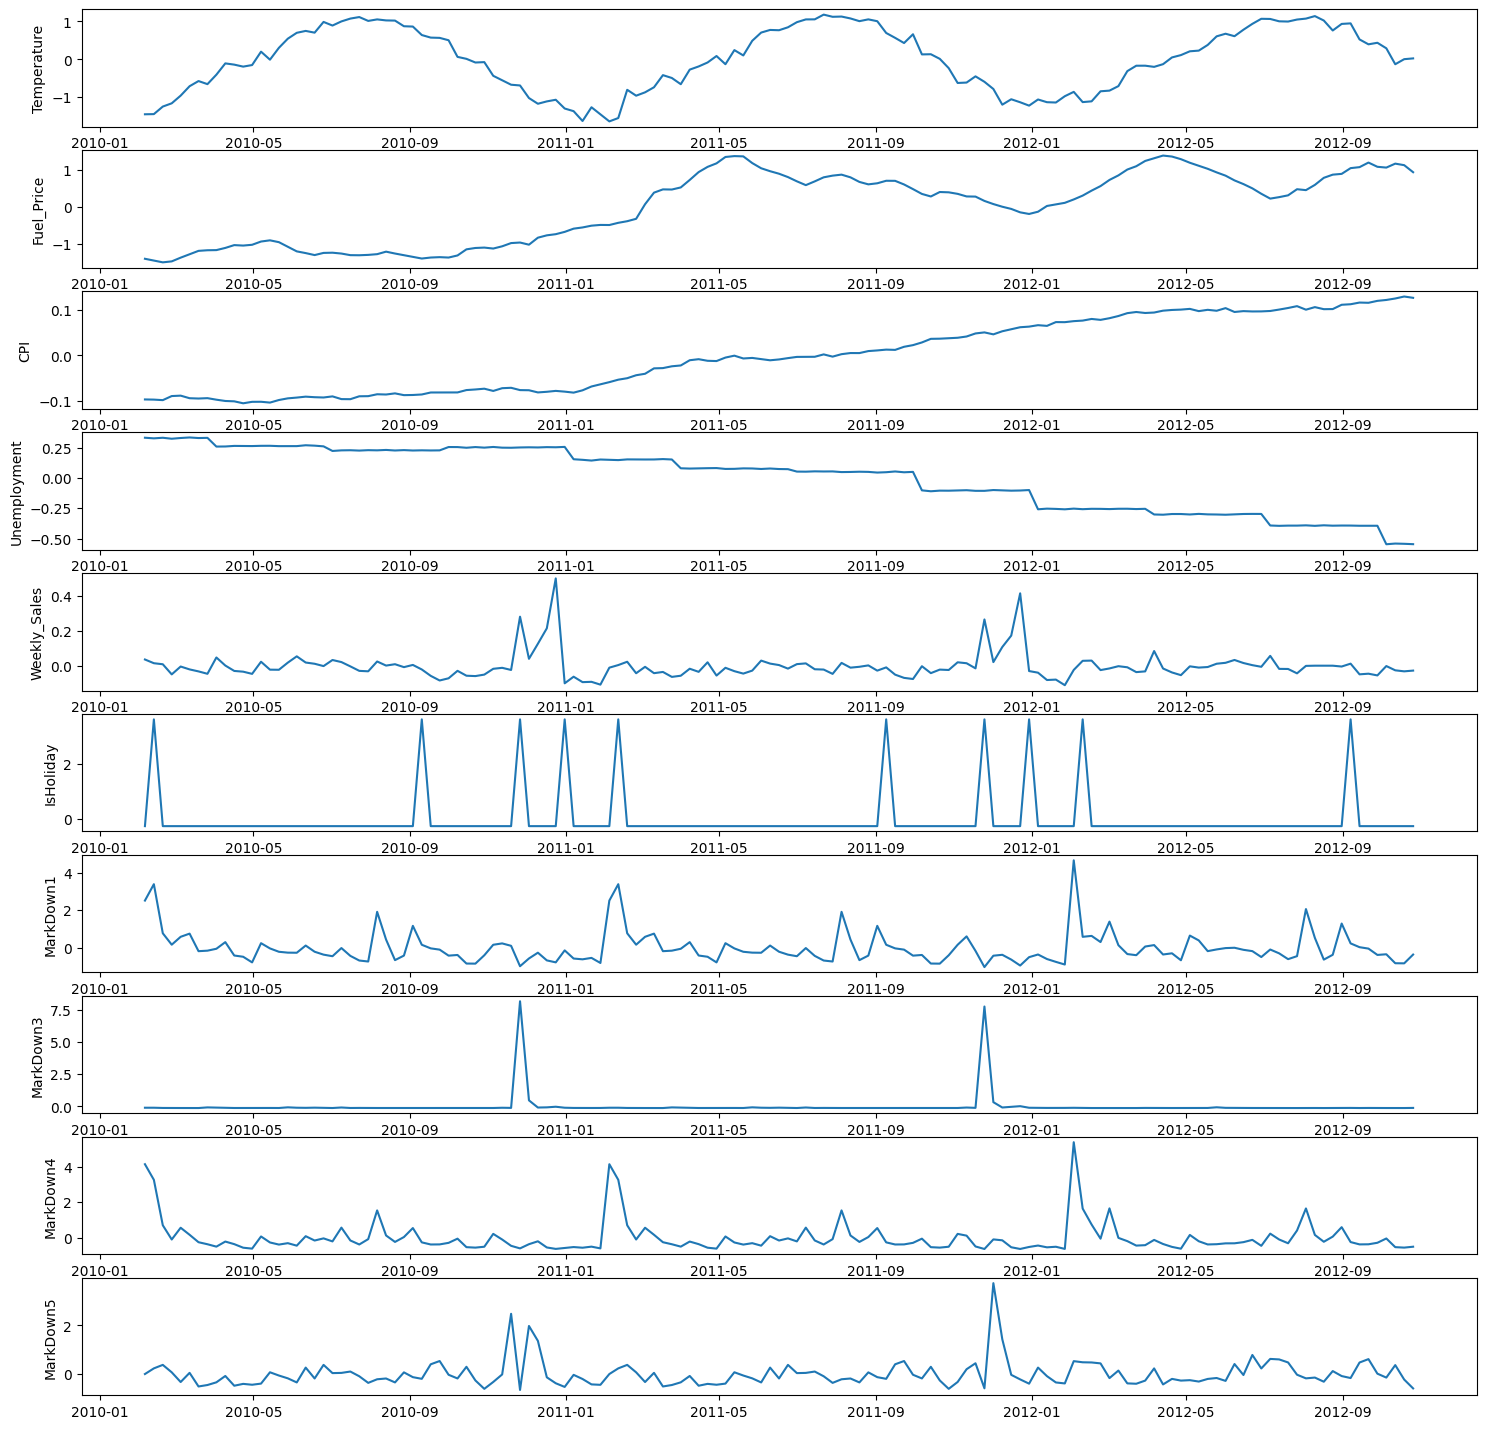

In [14]:
# Plotting all features
fig = plt.figure(figsize = (18, 18))
count_columns_ex_date = len(df_date.columns[1:])
for idx, col in enumerate(df_date.columns[1:]):
    plt.subplot(count_columns_ex_date, 1, idx+1)
    plt.plot(df_date["Date"], df_date[col])
    plt.ylabel(col)

## Success Factor Analysis

In [15]:
aggregated_df = df.groupby(['Store', 'Date']).agg({
    'Type': 'mean',
    'Size': 'mean',
    'Dept': 'mean',
    'Weekly_Sales': 'sum',  # Sum the weekly sales for each store and week
    'IsHoliday': 'mean',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'MarkDown1': 'mean',
    'MarkDown3': 'mean',
    'MarkDown4': 'mean',
    'MarkDown5': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).reset_index()

In [16]:
aggregated_df.drop("Dept", axis=1, inplace= True)
aggregated_df["Relative Sales"] = aggregated_df["Weekly_Sales"] / aggregated_df["Size"]
aggregated_df.head()

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales
0,-1.658199,2010-02-05,-0.885307,0.239209,21.005494,-0.275106,-0.963798,-1.720834,2.510646,-0.110208,4.135339,-0.003344,1.018774,0.078201,87.812322
1,-1.658199,2010-02-12,-0.885307,0.239209,21.632842,3.634961,-1.169783,-1.773177,3.380049,-0.110327,3.256627,0.230207,1.022498,0.078201,90.434916
2,-1.658199,2010-02-19,-0.885307,0.239209,19.608703,-0.275106,-1.092810,-1.847330,0.776302,-0.127816,0.700341,0.374179,1.023697,0.078201,81.973115
3,-1.658199,2010-02-26,-0.885307,0.239209,11.407477,-0.275106,-0.729625,-1.744825,0.170943,-0.132057,-0.100926,0.067283,1.024476,0.078201,47.688338
4,-1.658199,2010-03-05,-0.885307,0.239209,17.091813,-0.275106,-0.736672,-1.605243,0.589593,-0.132519,0.560425,-0.332666,1.025255,0.078201,71.451392


In [17]:
#find top 5 stores of last 3 months 
filtered_df = aggregated_df[(aggregated_df["Date"]>= "2012-08-03") &(aggregated_df["Date"]<="2012-10-26")]

#group by store and sum up relative sales
store_sales_sum = filtered_df.groupby('Store')['Relative Sales'].sum().reset_index()

# Sort the stores by the sum of "Relative Sales" in descending order and get the top 5 stores
top_5_stores = store_sales_sum.nlargest(5, 'Relative Sales')

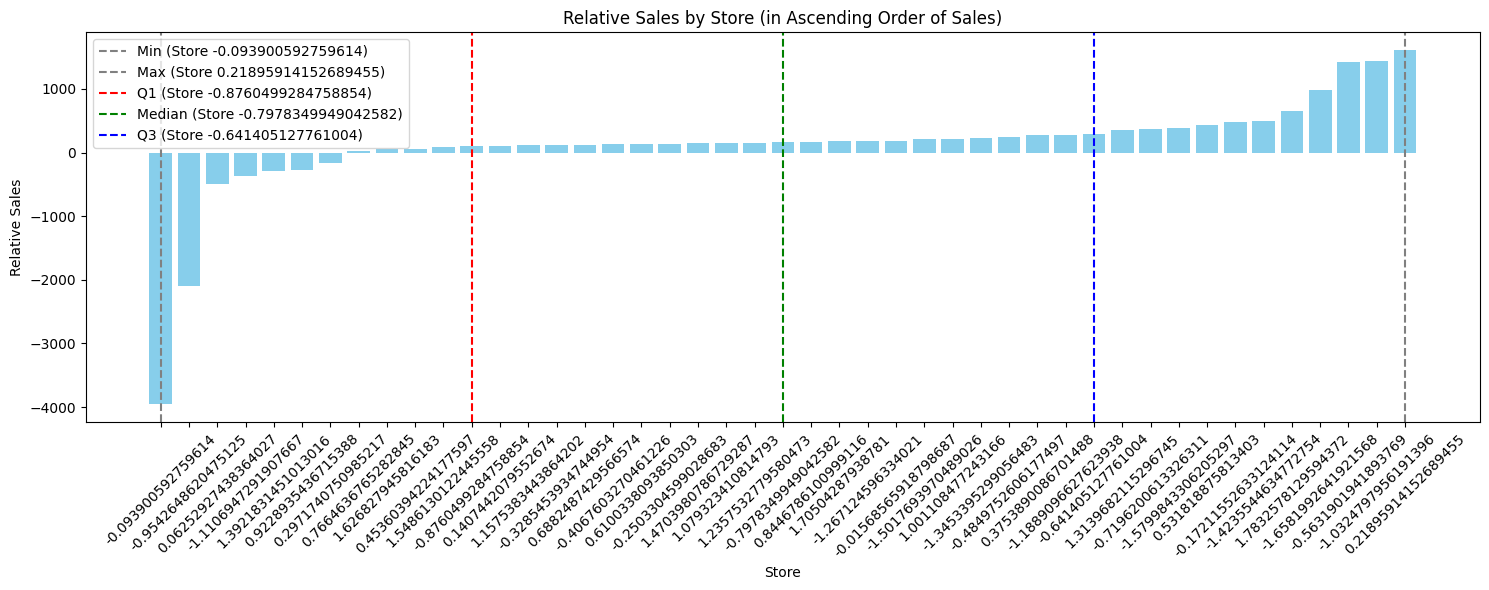

In [18]:
# Sort the dataframe by 'Relative Sales' for the purpose of plotting
sorted_df = store_sales_sum.sort_values(by="Relative Sales", ascending=True)

# Calculate statistics
min_value = sorted_df['Relative Sales'].min()
max_value = sorted_df['Relative Sales'].max()
first_quartile = sorted_df['Relative Sales'].quantile(0.25)
median_value = sorted_df['Relative Sales'].quantile(0.5)
third_quartile = sorted_df['Relative Sales'].quantile(0.75)

# Find the stores corresponding to these statistics
min_store = sorted_df[sorted_df['Relative Sales'] == min_value]['Store'].values[0]
max_store = sorted_df[sorted_df['Relative Sales'] == max_value]['Store'].values[0]
first_quartile_store = sorted_df[sorted_df['Relative Sales'] == first_quartile]['Store'].values[0]
median_store = sorted_df[sorted_df['Relative Sales'] == median_value]['Store'].values[0]
third_quartile_store = sorted_df[sorted_df['Relative Sales'] == third_quartile]['Store'].values[0]

# Create bar chart
plt.figure(figsize=(15, 6))
bars = plt.bar(sorted_df['Store'].astype(str), sorted_df['Relative Sales'], color='skyblue')  # Convert store numbers to strings

# Adding labels and title
plt.xlabel('Store')
plt.ylabel('Relative Sales')
plt.title('Relative Sales by Store (in Ascending Order of Sales)')

# Draw vertical lines for the quartiles, min, and max
plt.axvline(x=0, color='grey', linestyle='--', label=f'Min (Store {min_store})')
plt.axvline(x=44, color='grey', linestyle='--', label=f'Max (Store {max_store})')
plt.axvline(x=11, color='r', linestyle='--', label=f'Q1 (Store {first_quartile_store})')
plt.axvline(x=22, color='g', linestyle='--', label=f'Median (Store {median_store})')
plt.axvline(x=33, color='b', linestyle='--', label=f'Q3 (Store {third_quartile_store})')

plt.legend()
plt.xticks(rotation=45)  # Rotate store labels for better readability
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
top_5_stores
#the 43, 42,10,37,23

In [19]:
store_sales_sum.sort_values(by="Relative Sales", ascending=False, inplace=True)

store_sales_sum

,Store,Relative Sales
24,0.218959,1610.594458
8,-1.032480,1435.061004
14,-0.563190,1426.265163
0,-1.658199,979.825921
44,1.783258,654.971918
3,-1.423554,498.954156
19,-0.172116,483.323260
28,0.531819,433.068815
1,-1.579984,389.341345
12,-0.719620,362.587867


In [20]:
top5 = [43, 42, 10, 37, 23]
top5_df = filtered_df[filtered_df["Store"].isin(top5)]
top5_df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales


In [21]:
top5_df = top5_df.sort_values(by = ["Store", "Date"], ascending=[True, True])
top5_df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales


In [22]:
droptop = ["MarkDown1", "MarkDown3","MarkDown4","MarkDown5"]
top5_df.drop(droptop, axis=1, inplace=True)

c:\Users\blk\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\blk\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


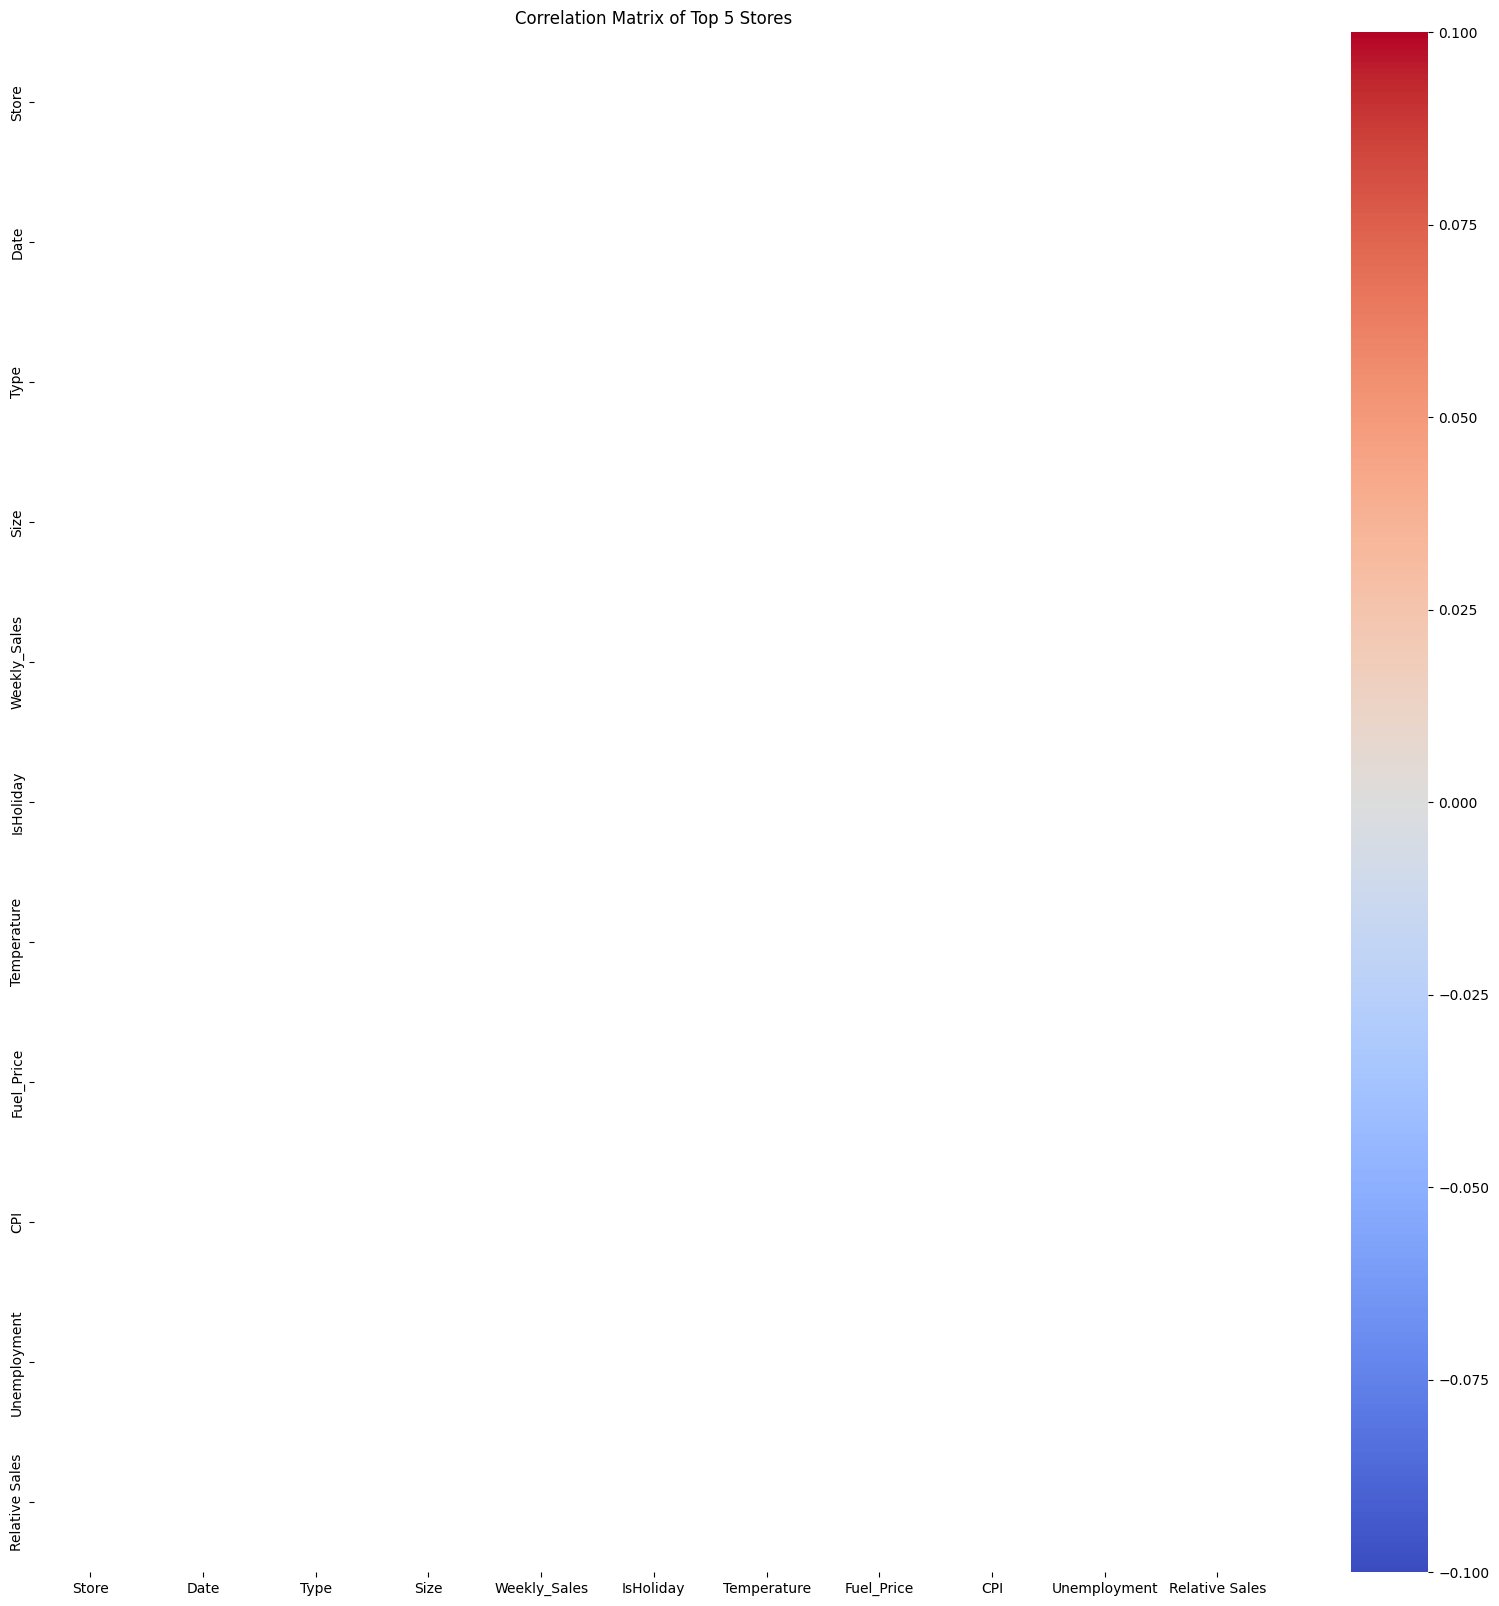

In [23]:
#correlation matrix for Top5

corr_matrix = top5_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Correlation Matrix of Top 5 Stores")
plt.show()

In [24]:
low_5_stores = store_sales_sum.nsmallest(5, 'Relative Sales')
low_5_stores

,Store,Relative Sales
20,-0.093901,-3954.279040
9,-0.954265,-2088.838562
22,0.062529,-497.943199
7,-1.110695,-366.977118
39,1.392183,-282.071765


In [25]:
low5 = [9, 15, 21, 25, 29]
low5_df = filtered_df[filtered_df["Store"].isin(low5)]
low5_df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales


In [26]:
low5_df = low5_df.sort_values(by = ["Store", "Date"], ascending=[True, True])
low5_df["Type"].unique()

array([], dtype=float64)

In [27]:
drop = ["MarkDown1", "MarkDown3","MarkDown4","MarkDown5", "Type", "Weekly_Sales"]
low5_df.drop(drop, axis=1, inplace=True)

c:\Users\blk\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\blk\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


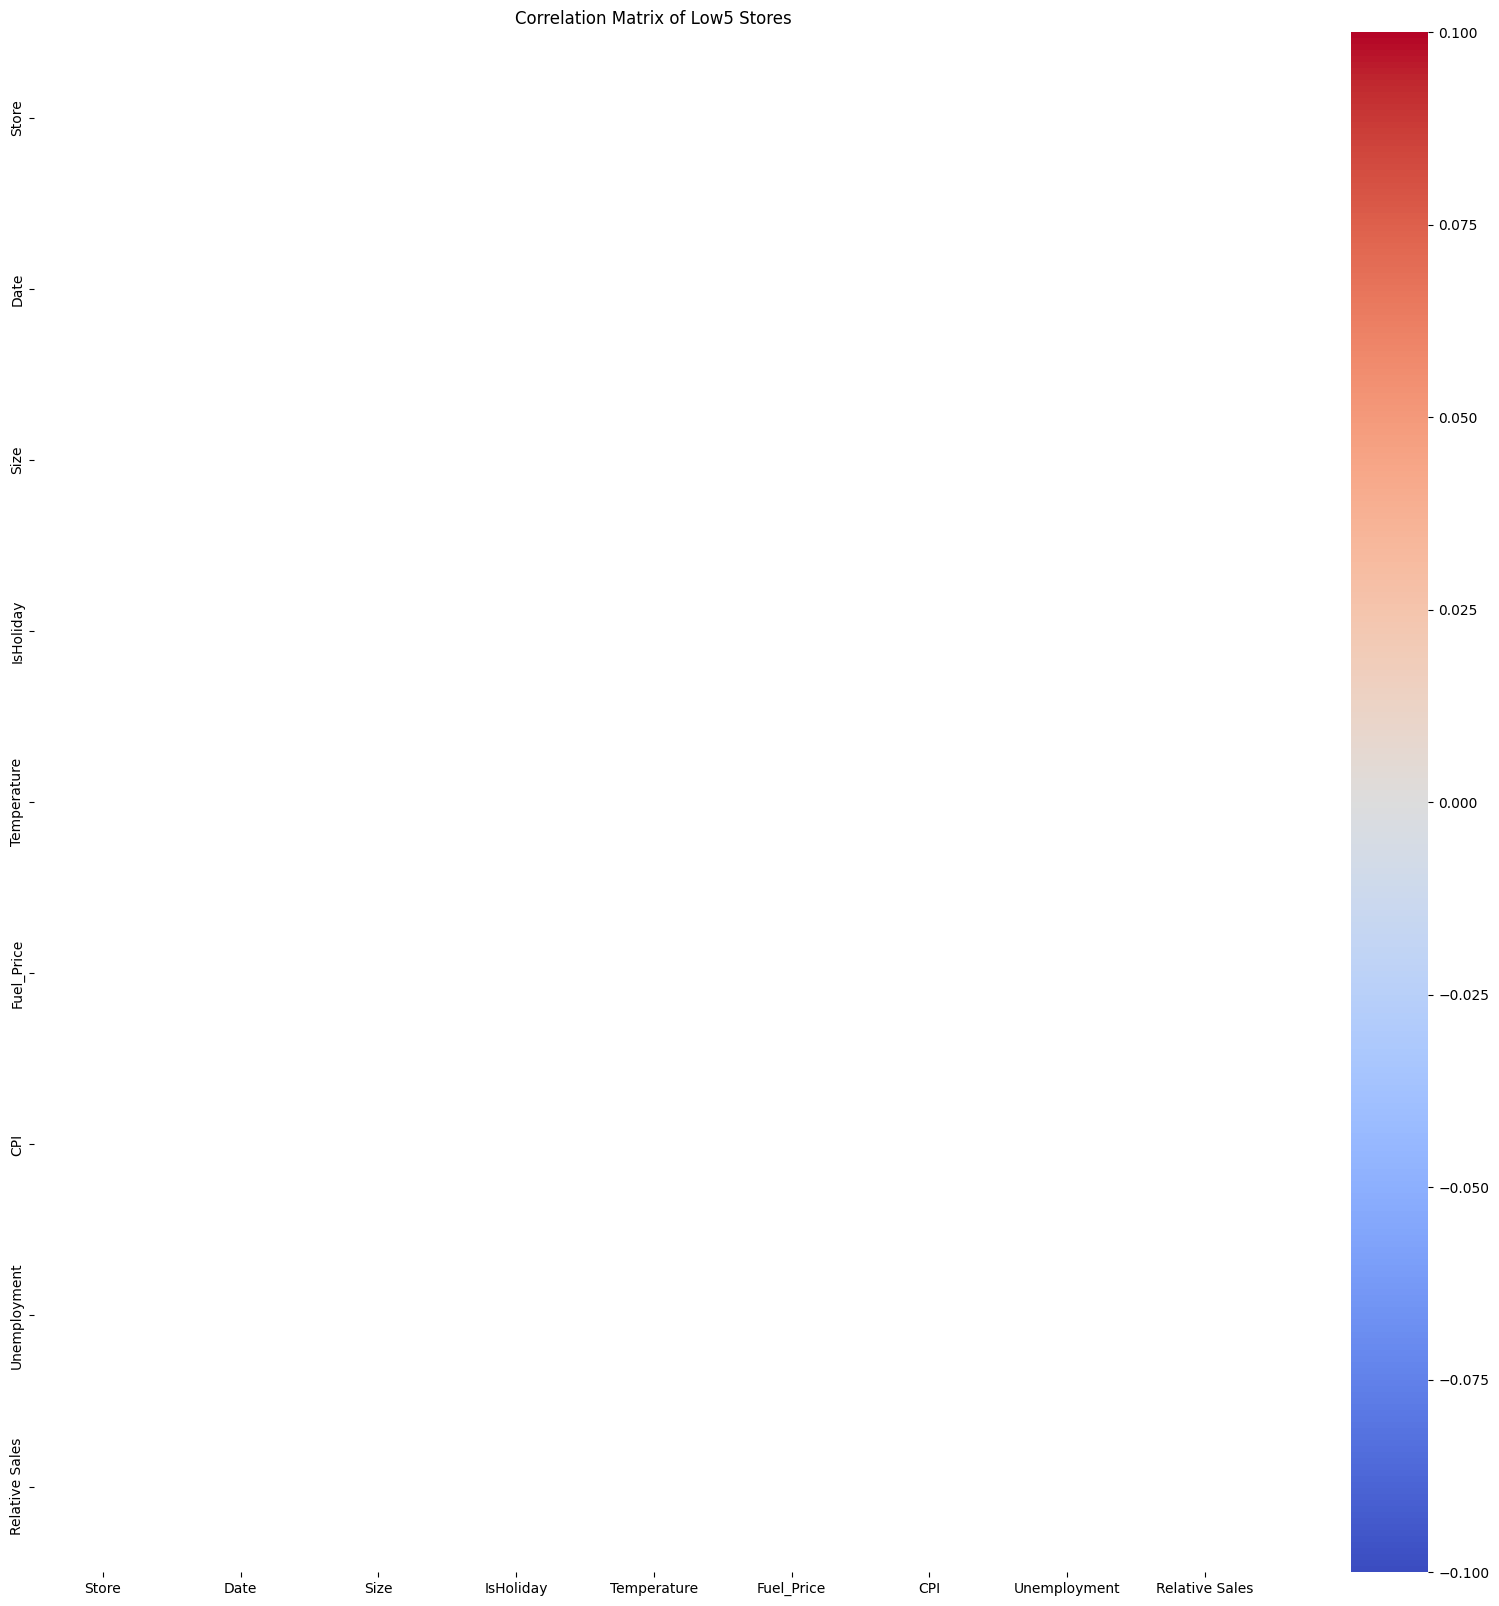

In [28]:
#correlation matrix for low5

corr_matrix = low5_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Correlation Matrix of Low5 Stores")
plt.show()

In [29]:
dfr = [top5_df, low5_df]
df = pd.concat(dfr)
df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Relative Sales


In [30]:
df.dropna(axis=1, inplace = True)

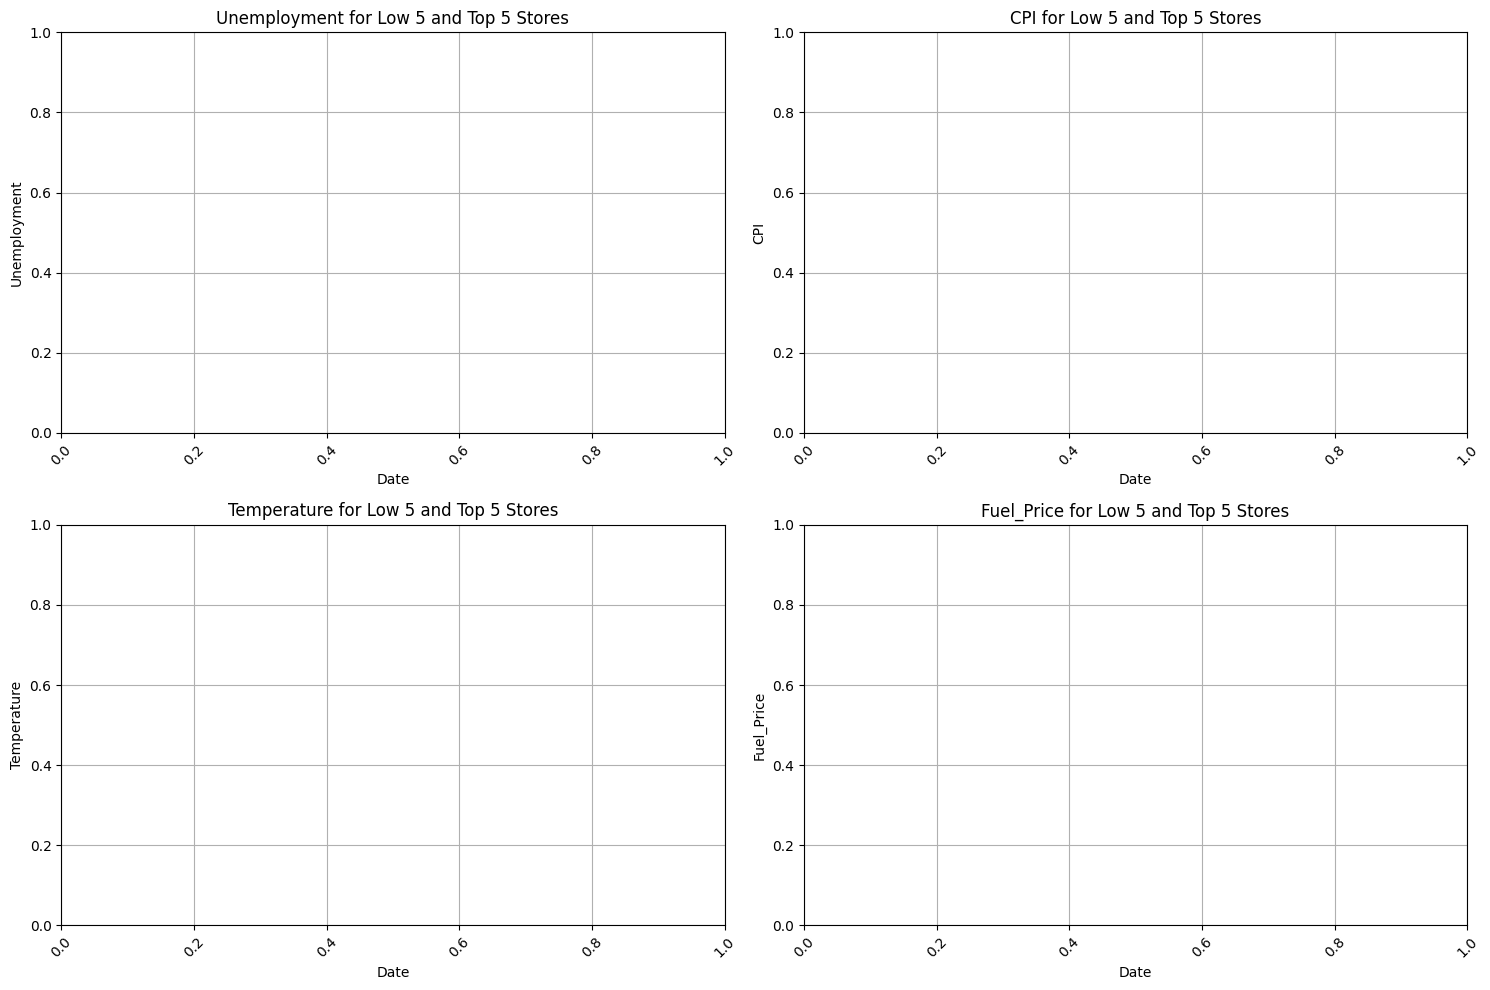

In [31]:
#line chart for selected features
#features = df.columns
features = ["Unemployment", "CPI", "Temperature", "Fuel_Price"]

# Define the stores that will be plotted
stores = df['Store'].unique()

plt.figure(figsize=(15, 10))

# Define colors for low5 and top5 stores
colors = {}
low5 = [9, 15, 21, 25, 29]
top5 = [43, 42, 10, 37, 23]

for store in stores:
    if store in low5:
        colors[store] = 'red'
    elif store in top5:
        colors[store] = 'green'
    
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.title(f'{feature} for Low 5 and Top 5 Stores')
    plt.xlabel('Date')
    plt.ylabel(feature)

    for store in stores:
        store_data = df[df['Store'] == store]
        plt.plot(store_data['Date'], store_data[feature], label=f'Store {store}', color=colors[store])

    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Prediction Models

`Feature Engineering and Data Preperation`

In [33]:
# Creating time features 
df_scaled['DayOfMonth'] = df_scaled['Date'].dt.day
df_scaled['DayOfWeek'] = df_scaled['Date'].dt.dayofweek
df_scaled['Quarter'] = df_scaled['Date'].dt.quarter
df_scaled['Month'] = df_scaled['Date'].dt.month
df_scaled['Year'] = df_scaled['Date'].dt.year
df_scaled['DayOfYear'] = df_scaled['Date'].dt.dayofyear
df_scaled['WeekOfYear'] = df_scaled['Date'].dt.isocalendar().week

In [11]:
# Splitting the data into train- and test set
split_indx = int(0.8*len(df_scaled))

train = df_scaled[:split_indx]
test = df_scaled[split_indx:]

In [12]:
# Setting date as index 
train = train.set_index('Date')
test = test.set_index('Date')

In [13]:
# Defining target variable and features 
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']

`Linear Regression`

In [14]:
# Initialize Linear Regression 
osl = LinearRegression()
osl.fit(X_train, y_train)

LinearRegression()

In [27]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['OSL_Predictions'] = osl.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(test['Weekly_Sales'], test['OSL_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['OSL_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['OSL_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.7133
Mean Absolute Error: 0.5144
R-squared: -0.0158


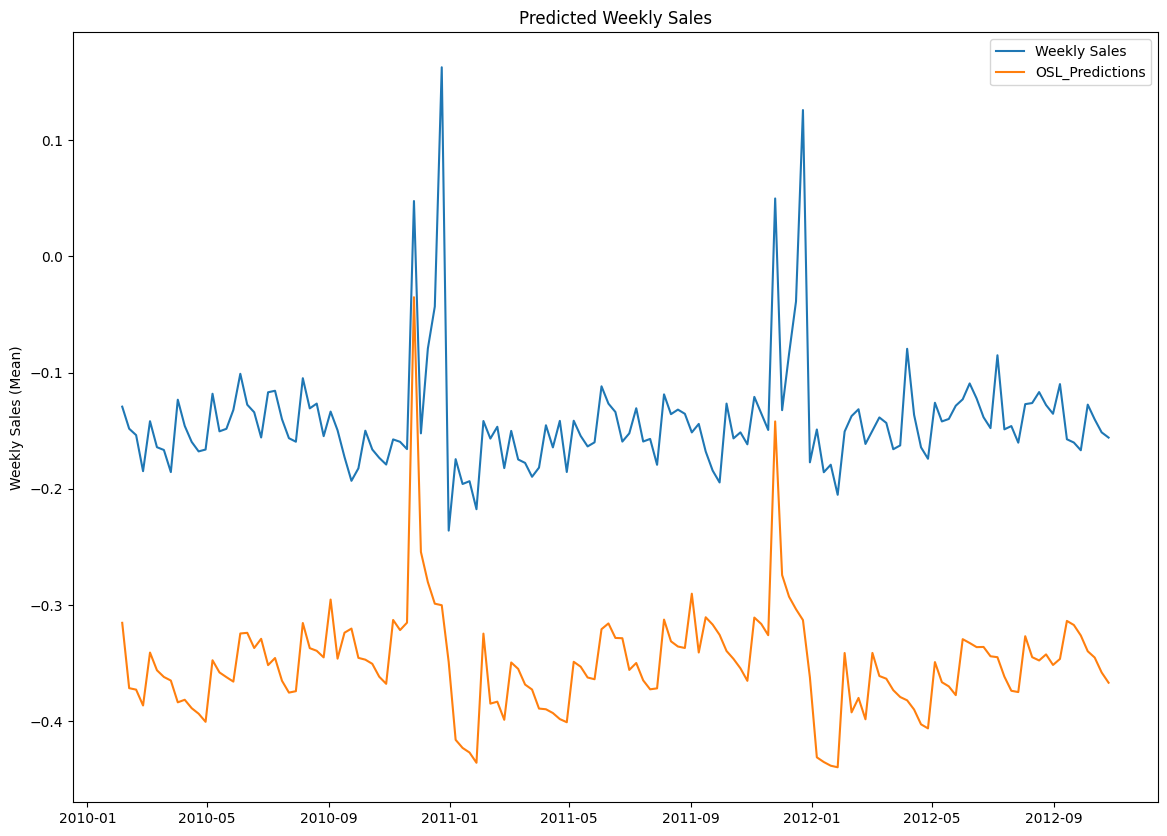

In [16]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'OSL_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['OSL_Predictions'], label='OSL_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

`Random Forest Regressor`

In [24]:
# Initializing Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [25]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['RF_Predictions'] = rf.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(test['Weekly_Sales'], test['RF_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['RF_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['RF_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.1678
Mean Absolute Error: 0.1981
R-squared: 0.7610


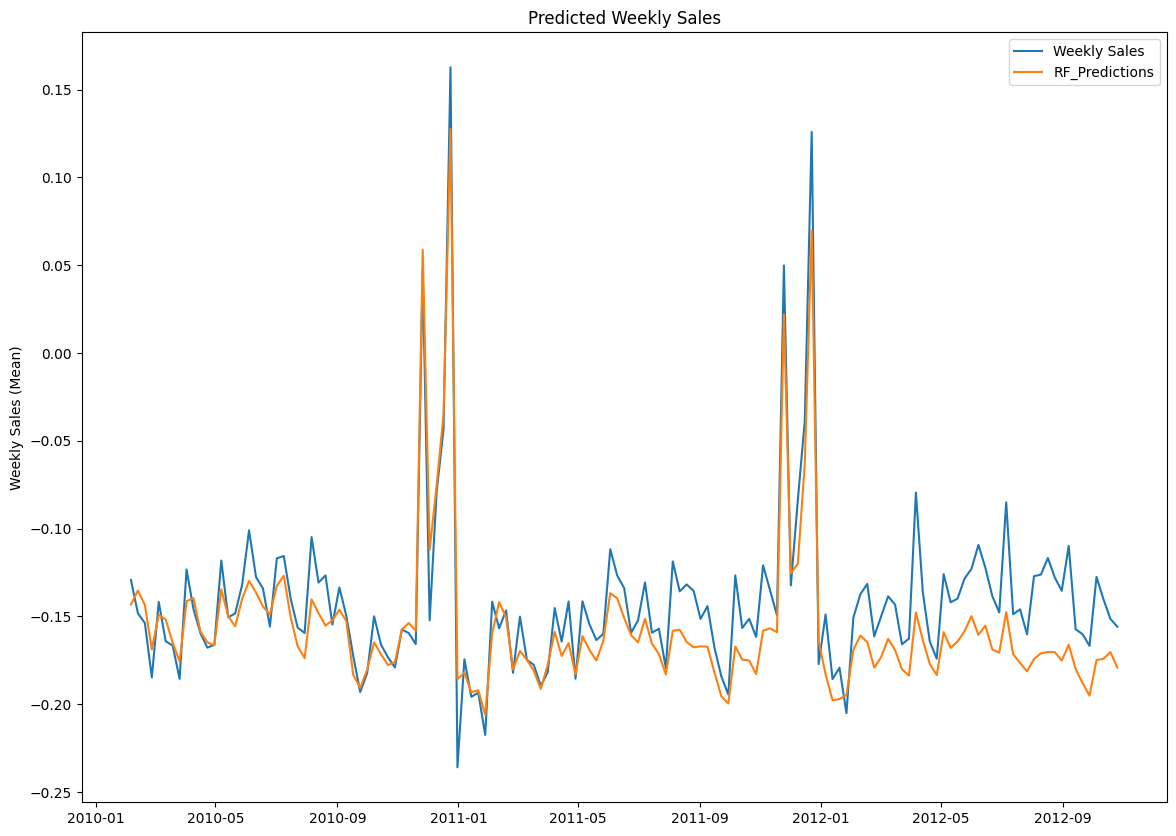

In [26]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'RF_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['RF_Predictions'], label='RF_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

`XGBoost regressor`

In [17]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train,y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['XGB_Predictions'] = xgb.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(test['Weekly_Sales'], test['XGB_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['XGB_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['XGB_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.2072
Mean Absolute Error: 0.2867
R-squared: 0.7049


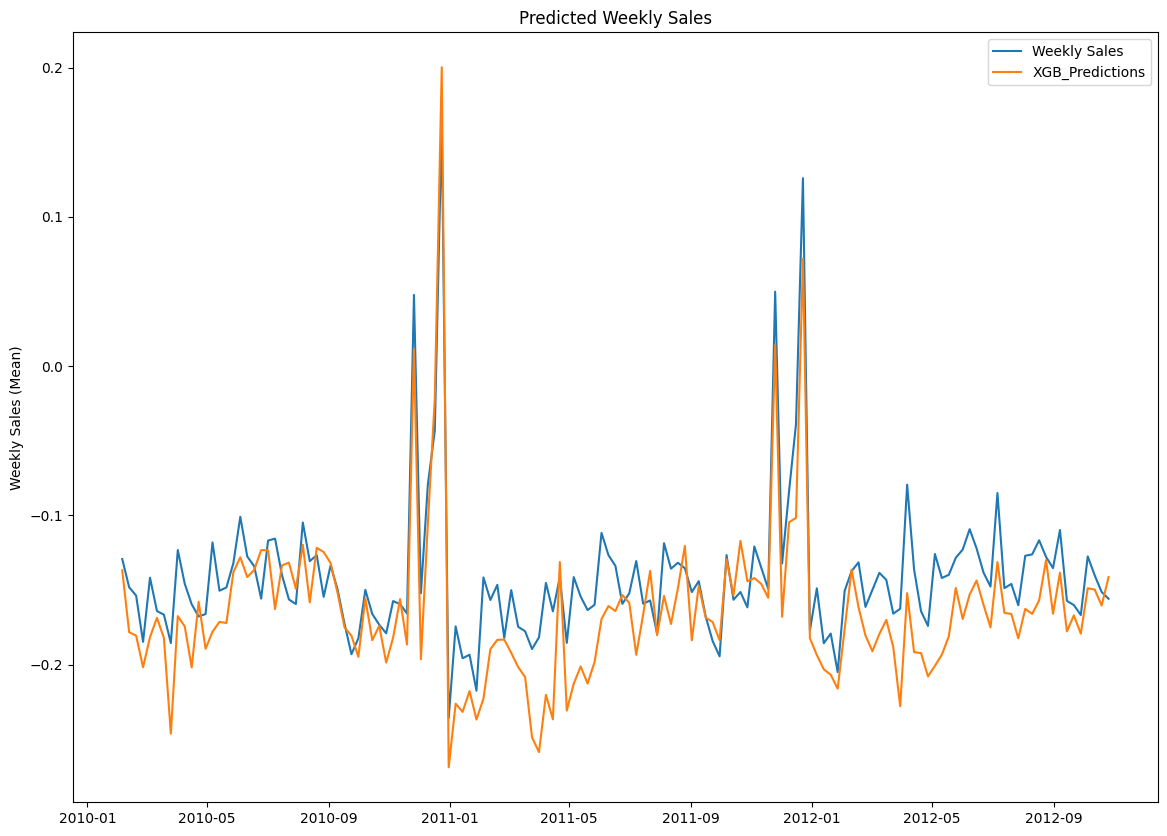

In [19]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'XGB_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['XGB_Predictions'], label='XGB_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()